# LGBM 모델

* 작업하는데 필요한 코드만 옮겨봄

In [106]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import random
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn import metrics 
from sklearn import svm

## 0. **데이터 로드**
* 훈련에 필요없는 index 컬럼 삭제
* train : `train.csv`
* test : `test.csv`

In [107]:
# 데이터 불러오기
train = pd.read_csv('./train.csv')
train = train.drop(['index'], axis=1)

test = pd.read_csv('./test.csv')
test = test.drop(['index'], axis=1)

submit = pd.read_csv('./sample_submission.csv')

## 1. **데이터 셋 확인**

## 2. **결측치 처리**
* 결측치는 직업 유형에만 존재함 -> 'unfilled'로 대체함. 

In [108]:
# 결측치 처리
print()
train['occyp_type'].fillna('unfilled', inplace=True) # 직업 유형 경우, 결측치가 많아서 따로 'unfilled' 라고 채움
test['occyp_type'].fillna('unfilled', inplace=True)

# 확인
print('훈련데이터 결측치 합 \n', train.isnull().sum())
print('테스트데이터 결측치 합 \n', test.isnull().sum())


훈련데이터 결측치 합 
 gender           0
car              0
reality          0
child_num        0
income_total     0
income_type      0
edu_type         0
family_type      0
house_type       0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
FLAG_MOBIL       0
work_phone       0
phone            0
email            0
occyp_type       0
family_size      0
begin_month      0
credit           0
dtype: int64
테스트데이터 결측치 합 
 gender           0
car              0
reality          0
child_num        0
income_total     0
income_type      0
edu_type         0
family_type      0
house_type       0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
FLAG_MOBIL       0
work_phone       0
phone            0
email            0
occyp_type       0
family_size      0
begin_month      0
dtype: int64


## 3. **이상치 처리**
* 정수형, 실수형 데이터에서 이상치 찾아보고, 그에 맞게 처리하자.

### **3-1. 각 컬럼 데이터 변환 and 이상치 처리**
* 정수/실수형 데이터를 가진 10개 컬럼 중 휴대전화/직장전화/가정용전화/이메일 보유여부는 이상치 없음. (1아니면 0이니깐)
* 이 외에 6개 컬럼들 하나씩 살펴보기
 * 6개: 자녀 수, 가족 규모, 연간 소득, 출생일, 업무 시작일, 신용카드 발급 월 
 * 또한 분석하기 용이하게 데이터 변경 (ex) 부호 변환 or 일 수를 나이로)

#### 1) 자녀 수

In [109]:
print('train childnum unique:', train['child_num'].unique())

train childnum unique: [ 0  1  2  3  4  5 14 19  7]


childnum unique: [0 1 2 3 4 5]


<AxesSubplot:xlabel='child_num'>

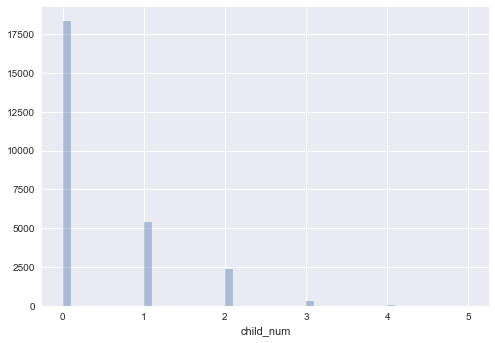

In [110]:
# 아이가 6명 이상인 데이터는 5로 변경
train.loc[train['child_num'] >= 6,'child_num']=5
print('childnum unique:', train['child_num'].unique())
sns.distplot(train['child_num'], kde=False, label='child_num')

#### 2) 가족 규모

In [111]:
print('train familysize unique:', train['family_size'].unique())

train familysize unique: [ 2.  3.  4.  1.  5.  6.  7. 15. 20.  9.]


In [112]:
train.loc[train['family_size'] >= 8,'family_size']=7

train familysize unique: [2. 3. 4. 1. 5. 6. 7.]


<AxesSubplot:xlabel='family_size'>

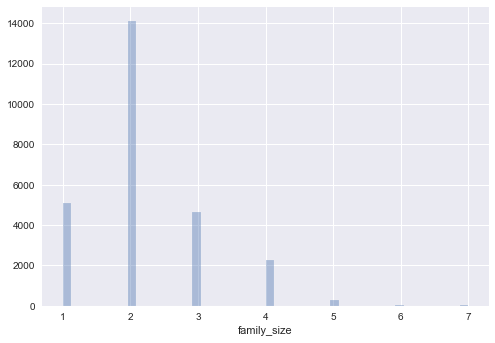

In [113]:
print('train familysize unique:', train['family_size'].unique())
sns.distplot(train['family_size'], kde=False, label='family_size')

#### 3) 연간 소득
* 테스트 데이터에서도 박스플롯 밖의 값이 많이 있기에 박스플롯 밖의 값 제거 안하기로 결정
* 정규분포 화 시켜서 학습 해보기

Text(0.5, 1.0, 'test Boxplot of income_total')

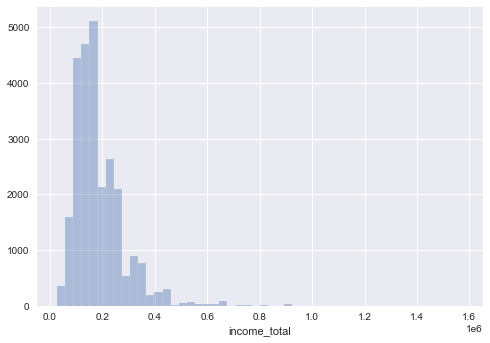

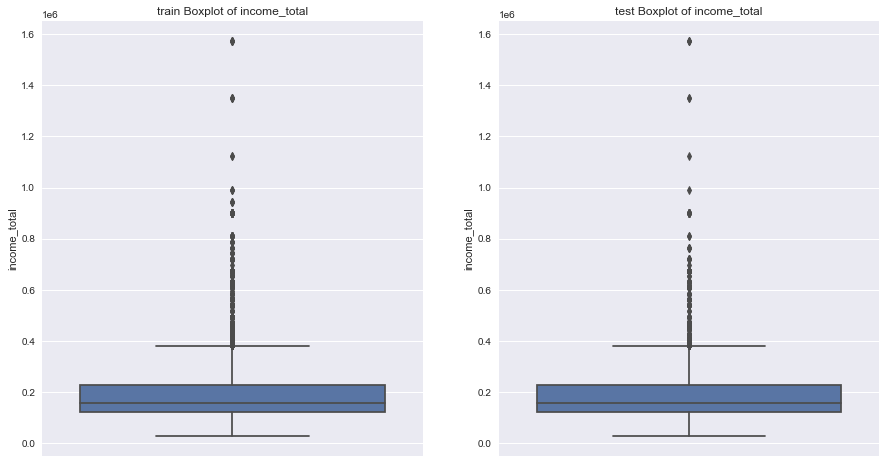

In [114]:
sns.distplot(train['income_total'], kde=False, label='income_total')
fig, ax = plt.subplots(1, 2, figsize=(15,8))
sns.boxplot(y=train["income_total"],data=train, ax=ax[0])
ax[0].set_title("train Boxplot of income_total")

sns.boxplot(y=test["income_total"],data=test, ax=ax[1])
ax[1].set_title("test Boxplot of income_total")

#### 4) 출생일 -> 나이
* 양수 변환 후 나이로 변환
* 정수형으로 변환

In [115]:
def days_to_age(x):
    return (x*-1)/365

# train
train['DAYS_BIRTH'] = train['DAYS_BIRTH'].apply(days_to_age)
train['DAYS_BIRTH'] = train['DAYS_BIRTH'].astype({'DAYS_BIRTH':'int'})
display(train['DAYS_BIRTH'])

# test
test['DAYS_BIRTH'] = test['DAYS_BIRTH'].apply(days_to_age)
test['DAYS_BIRTH'] = test['DAYS_BIRTH'].astype({'DAYS_BIRTH':'int'})
display(test['DAYS_BIRTH'])

0        38
1        31
2        52
3        41
4        41
         ..
26452    33
26453    41
26454    27
26455    27
26456    53
Name: DAYS_BIRTH, Length: 26457, dtype: int32

0       60
1       51
2       43
3       52
4       48
        ..
9995    50
9996    29
9997    57
9998    45
9999    25
Name: DAYS_BIRTH, Length: 10000, dtype: int32

#### 5) 업무시작일 -> 업무 연차
* 양수 변환 후 연차로 변환
    * 단, 365243은 0연차로 변환
    * 135일 일한 사람과 0연차를 구분하기 위해서 0연차를 제외하고 모두 +1 해줌
* 정수형으로 변환

In [116]:
def days_to_year(x):
    if x==365243 :
        return 0
    return (x*-1)/365+1

# train
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(days_to_year)
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].astype({'DAYS_EMPLOYED':'int'})
display(train['DAYS_EMPLOYED'])

# test
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].apply(days_to_year)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].astype({'DAYS_EMPLOYED':'int'})
display(test['DAYS_EMPLOYED'])

0        13
1         5
2        13
3         6
4         6
         ..
26452     6
26453     7
26454     6
26455     1
26456     3
Name: DAYS_EMPLOYED, Length: 26457, dtype: int32

0        0
1       24
2        1
3        7
4       26
        ..
9995    15
9996     4
9997    39
9998     3
9999     1
Name: DAYS_EMPLOYED, Length: 10000, dtype: int32

#### 6) 신용카드 발급 월

* 양수로 변환

In [117]:
def minus(x):
    return x * -1

# train
train['begin_month'] = train['begin_month'].apply(minus)
display(train['begin_month'])

# test
test['begin_month'] = test['begin_month'].apply(minus)
display(test['begin_month'])

0         6.0
1         5.0
2        22.0
3        37.0
4        26.0
         ... 
26452     2.0
26453    47.0
26454    25.0
26455    59.0
26456     9.0
Name: begin_month, Length: 26457, dtype: float64

0       60
1       36
2       40
3       41
4        8
        ..
9995    19
9996    34
9997    55
9998    33
9999    11
Name: begin_month, Length: 10000, dtype: int64

#### 7) 박스플롯 부분 - 안넣음 

#### 8) 상관관계
* 범주형과 수치형 상관관계 확인 - https://dodonam.tistory.com/217

<AxesSubplot:>

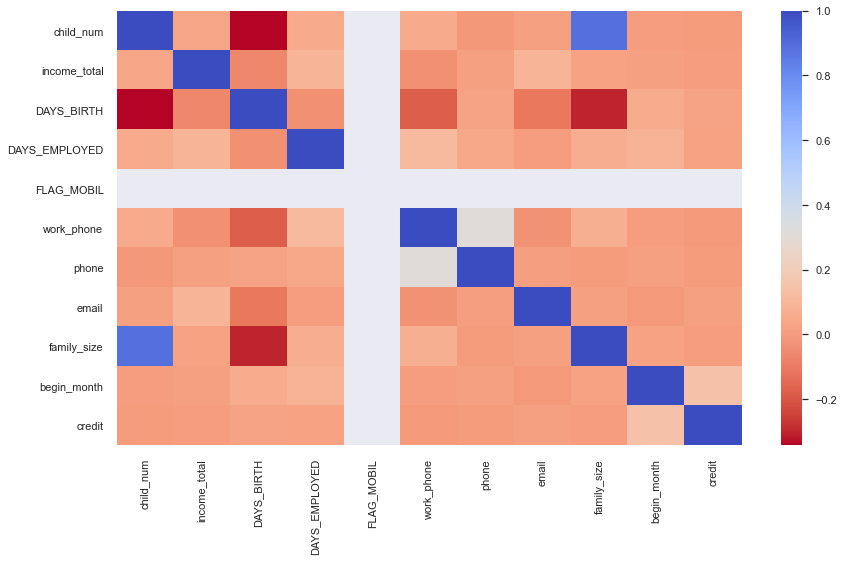

In [118]:
#상관관계를 확인
sns.set(rc={'figure.figsize':(14,8)})
corr = train.corr()
sns.heatmap(corr, cmap='coolwarm_r')

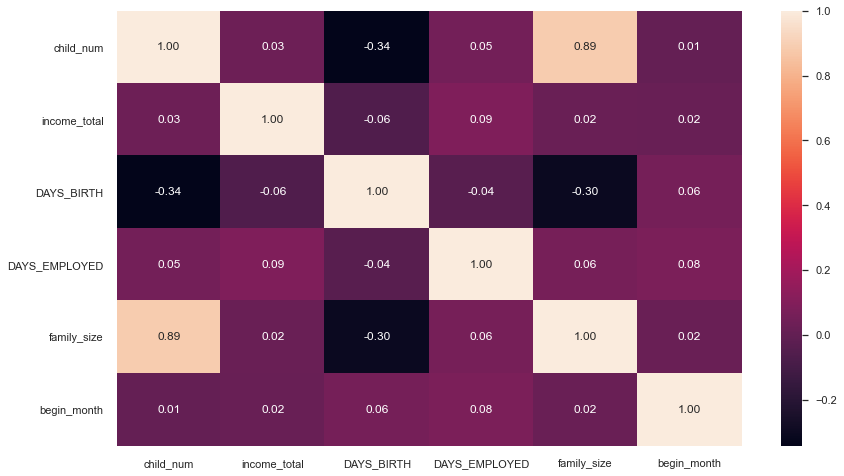

In [119]:
# 다중 공선성 확인
list_numeric = ["child_num", "income_total", "DAYS_BIRTH", "DAYS_EMPLOYED", "family_size", "begin_month"]
sns.heatmap(train[list_numeric].corr(), annot = True, fmt = ".2f")
plt.show()

#### 자녀 수 , 가족 숫자 중 한개 제거해보기

In [120]:
#상관관계 수치로 확인
# 종속변수('Class')와의 상관관계
Corr = train.corr()
IF = Corr['credit'].sort_values().to_frame()
display(IF.head(5))
print(IF)

,credit
work_phone,-0.003134
child_num,0.002601
phone,0.003452
family_size,0.007195
income_total,0.008555


                 credit
work_phone    -0.003134
child_num      0.002601
phone          0.003452
family_size    0.007195
income_total   0.008555
email          0.014812
DAYS_EMPLOYED  0.023476
DAYS_BIRTH     0.025059
begin_month    0.147477
credit         1.000000
FLAG_MOBIL          NaN


* 신용도와 가장 상관관계가 높은 컬럼은 "begin_month" 이나 0.147에 불과함

## 4. **Feature Engineering** 

* 수치형 컬럼은 기존 데이터 분포와 비슷하고, 어느정도 일정한 범위를 갖게 정규화해야함
* minmax 정규화 , 원핫 인코딩

### 4-1. 범주형 데이터 one-hot encoding, label encoding
* object (범주형)은 원핫인코딩 하기.
    * 단, occyp_type은 라벨 인코딩.
* 범주형 데이터를 가지는 변수 확인 (dtype가 object)
* gender(2), car(2), reality(2), income_type(5), edu_type(5), family_type(5), house_type(6), occyp_type(18)

In [121]:
# object 객체를 가지는 변수(열) 확인
object_col = []
for col in train.columns:
    if train[col].dtype == 'object' : # and col!='occyp_type': # 변수가 18개인 occyp_type만 제외
        object_col.append(col)
display(object_col)

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type']

In [122]:
print(train['occyp_type'].unique())
(len(train['occyp_type'].unique()))

['unfilled' 'Laborers' 'Managers' 'Sales staff' 'High skill tech staff'
 'Core staff' 'Drivers' 'Medicine staff' 'Accountants' 'Realty agents'
 'Security staff' 'Cleaning staff' 'Private service staff' 'Cooking staff'
 'Secretaries' 'HR staff' 'IT staff' 'Low-skill Laborers'
 'Waiters/barmen staff']


19

#### 4-1-1. train의 원핫인코딩, 라벨인코딩

In [123]:
# occyp_type을 제외한 모든 object객체 열을 onehot encoding

enc = OneHotEncoder()
enc.fit(train.loc[:,object_col])

train_onehot_df = pd.DataFrame(enc.transform(train.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
train.drop(object_col, axis=1, inplace=True)
train = pd.concat([train, train_onehot_df], axis=1)

In [124]:
# 인코딩 확인
display(train.head(5))

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,...,occyp_type_Low-skill Laborers,occyp_type_Managers,occyp_type_Medicine staff,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff,occyp_type_unfilled
0,0,202500.0,38,13,1,0,0,0,2.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,247500.0,31,5,1,0,0,1,3.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,450000.0,52,13,1,0,1,0,2.0,22.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,202500.0,41,6,1,0,1,0,2.0,37.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0,157500.0,41,6,1,0,0,0,2.0,26.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 4-1-2. test의 원핫인코딩, 라벨인코딩

In [125]:
# occyp_type을 제외한 모든 object객체 열을  onehot encoding
enc = OneHotEncoder()
enc.fit(test.loc[:,object_col])

test_onehot_df = pd.DataFrame(enc.transform(test.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
test.drop(object_col, axis=1, inplace=True)
test = pd.concat([test, test_onehot_df], axis=1)

In [126]:
# 인코딩 확인
display(test.head(5))

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,...,occyp_type_Low-skill Laborers,occyp_type_Managers,occyp_type_Medicine staff,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff,occyp_type_unfilled
0,0,112500.0,60,0,1,0,1,0,2,60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,135000.0,51,24,1,0,1,0,2,36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,69372.0,43,1,1,1,1,0,2,40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,112500.0,52,7,1,1,0,0,2,41,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,225000.0,48,26,1,1,0,0,2,8,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 4-2-1. MinMaxScaler

In [127]:
from sklearn.preprocessing import MinMaxScaler

MinMaxScaler_data = train[train.columns.difference(['credit'])].copy()

minMaxScaler = MinMaxScaler()
print(minMaxScaler.fit(MinMaxScaler_data))
train_data_minMaxScaled = minMaxScaler.transform(MinMaxScaler_data)

# MinMaxScaler_data - MinMaxScaler적용한 데이터 프레임
index = 0
for col in MinMaxScaler_data.columns :
    MinMaxScaler_data[col] = train_data_minMaxScaled[:,index]
    index = index + 1
display(MinMaxScaler_data)

MinMaxScaler()


,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,begin_month,car_N,car_Y,child_num,edu_type_Academic degree,edu_type_Higher education,edu_type_Incomplete higher,...,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff,occyp_type_unfilled,phone,reality_N,reality_Y,work_phone
0,0.361702,0.295455,0.0,0.100000,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.212766,0.113636,0.0,0.083333,1.0,0.0,0.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.659574,0.295455,0.0,0.366667,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.425532,0.136364,0.0,0.616667,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.425532,0.136364,0.0,0.433333,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0.255319,0.136364,0.0,0.033333,1.0,0.0,0.4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26453,0.425532,0.159091,0.0,0.783333,1.0,0.0,0.2,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
26454,0.127660,0.136364,0.0,0.416667,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26455,0.127660,0.022727,0.0,0.983333,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


<AxesSubplot:xlabel='begin_month', ylabel='Density'>

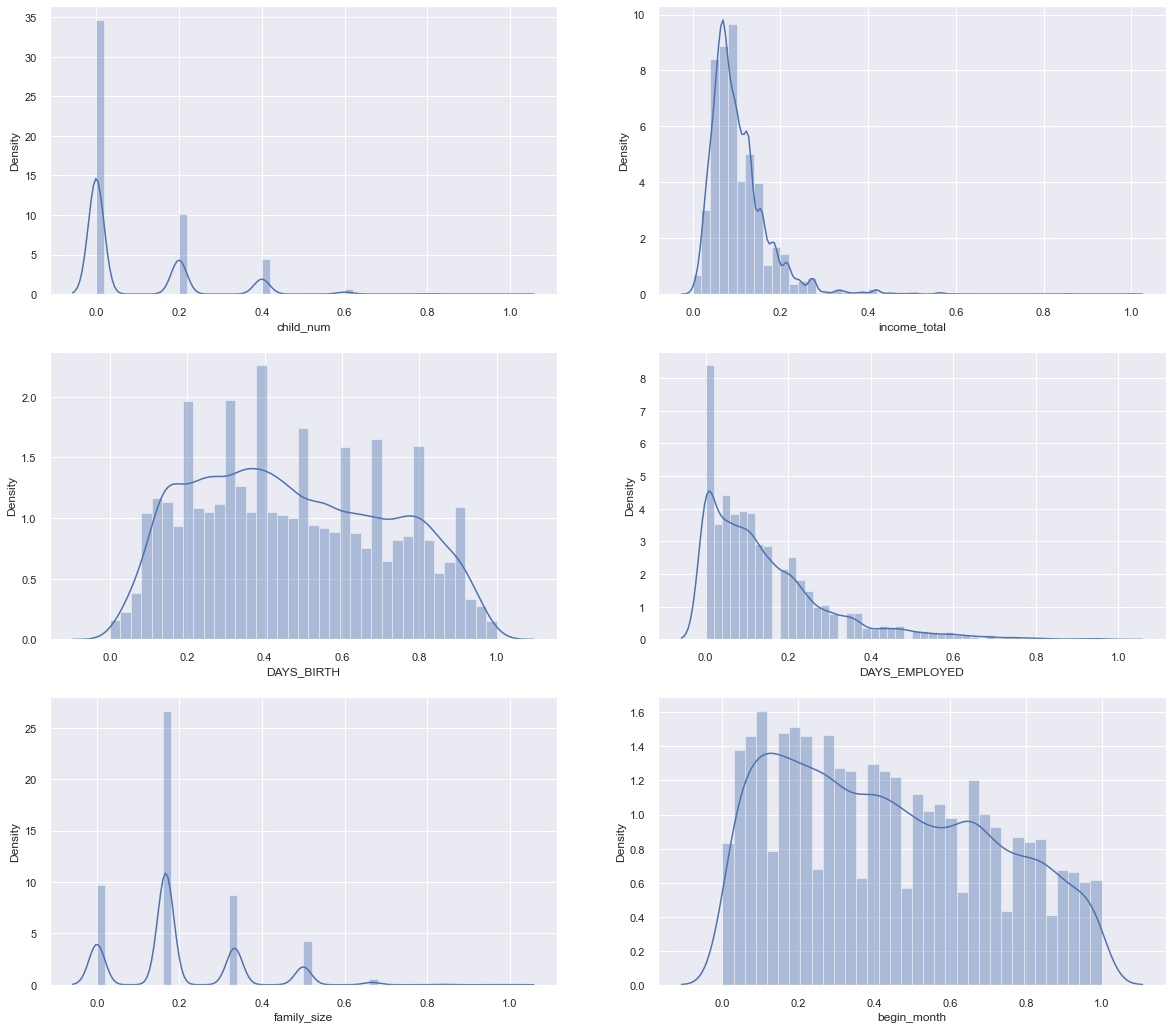

In [128]:
# MinMaxScaler 적용한 후 분포도 확인
fig, ax = plt.subplots(3, 2, figsize=(20,18))

sns.distplot(MinMaxScaler_data['child_num'], ax=ax[0][0])
sns.distplot(MinMaxScaler_data['income_total'], ax=ax[0][1])

sns.distplot(MinMaxScaler_data['DAYS_BIRTH'], ax=ax[1][0])
sns.distplot(MinMaxScaler_data['DAYS_EMPLOYED'], ax=ax[1][1])

sns.distplot(MinMaxScaler_data['family_size'], ax=ax[2][0])
sns.distplot(MinMaxScaler_data['begin_month'], ax=ax[2][1])

#### 4-2-4 RobustScaler

In [129]:
from sklearn.preprocessing import RobustScaler

RobustScaler_data = train[train.columns.difference(['credit'])].copy()

robustScaler = RobustScaler()
print(robustScaler.fit(RobustScaler_data))
train_data_robustScaled = robustScaler.transform(RobustScaler_data)

# StandardScaler_data - StandardScaler 적용한 데이터 프레임
index = 0
for col in RobustScaler_data.columns :
    RobustScaler_data[col] = train_data_robustScaled[:,index]
    index = index + 1
display(RobustScaler_data)

RobustScaler()


,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,begin_month,car_N,car_Y,child_num,edu_type_Academic degree,edu_type_Higher education,edu_type_Incomplete higher,...,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff,occyp_type_unfilled,phone,reality_N,reality_Y,work_phone
0,-0.210526,1.142857,0.0,-0.666667,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-1.0,0.0
1,-0.578947,0.000000,0.0,-0.703704,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.526316,1.142857,0.0,-0.074074,-1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.052632,0.142857,0.0,0.481481,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.052632,0.142857,0.0,0.074074,-1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,-0.473684,0.142857,0.0,-0.814815,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0
26453,-0.052632,0.285714,0.0,0.851852,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
26454,-0.789474,0.142857,0.0,0.037037,-1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0
26455,-0.789474,-0.571429,0.0,1.296296,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='begin_month', ylabel='Density'>

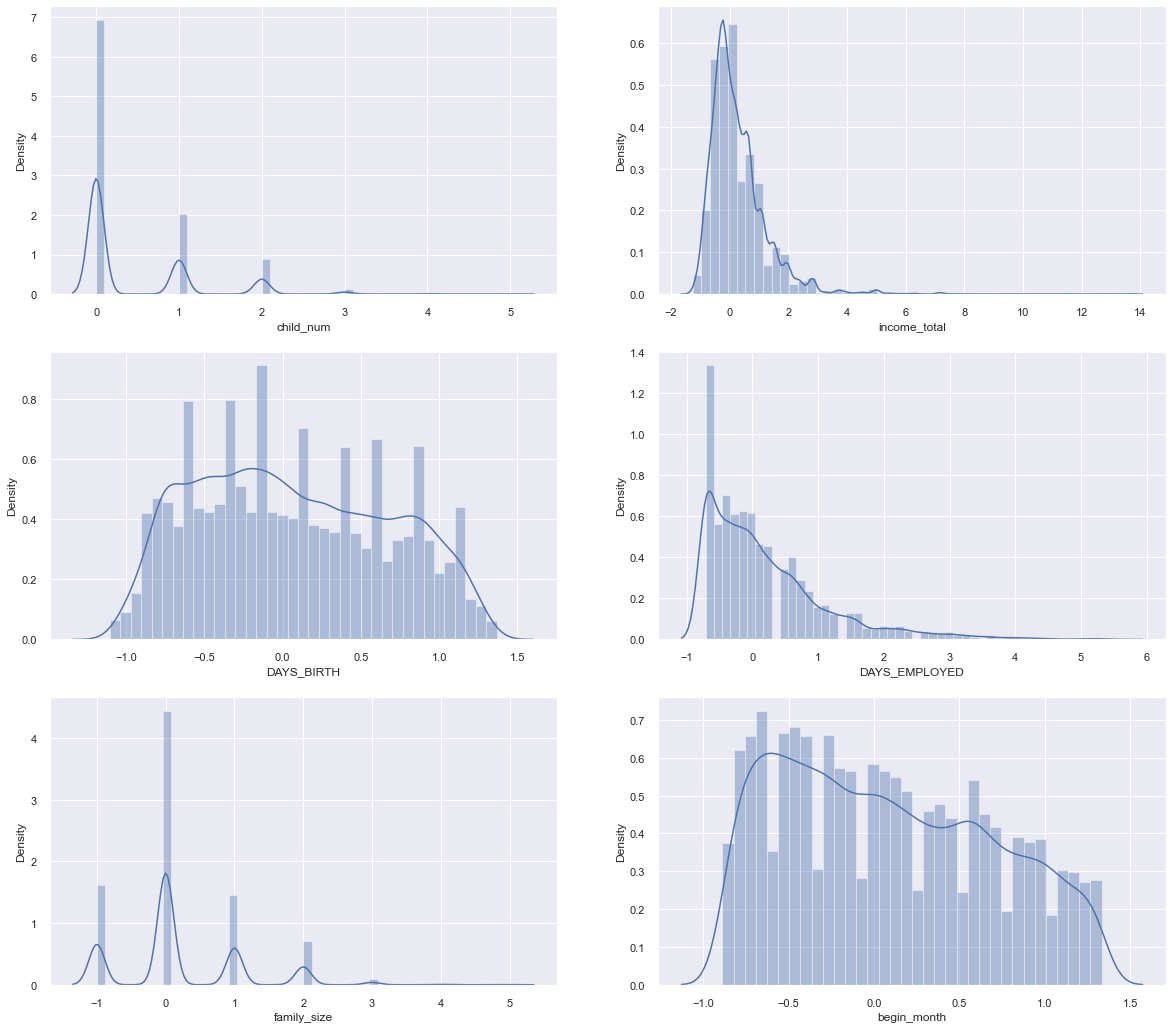

In [130]:
# MaxAbsScaler_data 적용한 후 분포도 확인
fig, ax = plt.subplots(3, 2, figsize=(20,18))

sns.distplot(RobustScaler_data['child_num'], ax=ax[0][0])
sns.distplot(RobustScaler_data['income_total'], ax=ax[0][1])

sns.distplot(RobustScaler_data['DAYS_BIRTH'], ax=ax[1][0])
sns.distplot(RobustScaler_data['DAYS_EMPLOYED'], ax=ax[1][1])

sns.distplot(RobustScaler_data['family_size'], ax=ax[2][0])
sns.distplot(RobustScaler_data['begin_month'], ax=ax[2][1])

In [131]:
# test.csv 정규화
from sklearn import preprocessing
testSet = test.copy()
# testSet=testSet[testSet.columns.difference(['child_num'])]
display(testSet.head())

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,...,occyp_type_Low-skill Laborers,occyp_type_Managers,occyp_type_Medicine staff,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff,occyp_type_unfilled
0,0,112500.0,60,0,1,0,1,0,2,60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,135000.0,51,24,1,0,1,0,2,36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,69372.0,43,1,1,1,1,0,2,40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,112500.0,52,7,1,1,0,0,2,41,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,225000.0,48,26,1,1,0,0,2,8,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [133]:
testSet = preprocessing.RobustScaler().fit(testSet).transform(testSet)

## 5. 모델링

### 5-0 데이터 분리
* 데이터 분리는 stratifiedKFold를 사용하여 y값 분포를 비슷하게 분리 시킴 -> 5-fold
    * StratifiedKFold(계층별 k-겹 교차검증) - 불균형한 분포도를 가진 레이블 데이터를 위한 방식, 특정 레이블 값이 너무 많거나 적은 경우
    * 타겟에 속성값의 개수를 동일하게 가져감으로써 kfold 같이 데이터가 한곳으로 몰리는 것을 방지
    * 대부분의 경우 회귀에서는 k-겹 교차 검증, 분류에서는 계층별 k-겹 교차검증의 기본값이 잘 작동함
* n_split는 몇 개로 분할할지 결정
* shtffle은 데이터 섞어서 샘플의 순서 랜덤하게. 
* 데이터를 섞을 때 random_state를 고정해서 똑같은 작업을 재현할 수있음
* 그렇지 않으면 cross_val_score를 실행할 때마다 폴드가 바뀌어 매번 결과가 달라짐

In [138]:
# 설명변수 X, 예측변수 y 할당 (사용하고자하는 정규화 스케일러로 변경 가능)
# X = MinMaxScaler_data[MinMaxScaler_data.columns.difference(['child_num'])]
X = RobustScaler_data
Y = train['credit']
display(X)

,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,begin_month,car_N,car_Y,child_num,edu_type_Academic degree,edu_type_Higher education,edu_type_Incomplete higher,...,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff,occyp_type_unfilled,phone,reality_N,reality_Y,work_phone
0,-0.210526,1.142857,0.0,-0.666667,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-1.0,0.0
1,-0.578947,0.000000,0.0,-0.703704,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.526316,1.142857,0.0,-0.074074,-1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.052632,0.142857,0.0,0.481481,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.052632,0.142857,0.0,0.074074,-1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,-0.473684,0.142857,0.0,-0.814815,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0
26453,-0.052632,0.285714,0.0,0.851852,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
26454,-0.789474,0.142857,0.0,0.037037,-1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0
26455,-0.789474,-0.571429,0.0,1.296296,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
folds=[]

# 계층별 k-겹 교차검증을 위해 인덱스를 나누는 코드
for train_index, valid_index in skf.split(X, Y):
    folds.append((train_index, valid_index))
display(folds)

[(array([    0,     1,     3, ..., 26453, 26454, 26456]),
  array([    2,    26,    45, ..., 26446, 26452, 26455])),
 (array([    2,     3,     6, ..., 26454, 26455, 26456]),
  array([    0,     1,     4, ..., 26435, 26447, 26450])),
 (array([    0,     1,     2, ..., 26453, 26454, 26455]),
  array([    3,    12,    16, ..., 26438, 26448, 26456])),
 (array([    0,     1,     2, ..., 26454, 26455, 26456]),
  array([    6,    14,    29, ..., 26440, 26442, 26453])),
 (array([    0,     1,     2, ..., 26453, 26455, 26456]),
  array([    7,     9,    10, ..., 26449, 26451, 26454]))]

### 5-1. LGBM
[LGBM 모델 설명](https://lsjsj92.tistory.com/548)
#### Training    
* LGBM의 기본 파라미터로 훈련
* 30번 이상 개선 없을 경우 중단.
* 각 5개의 fold를 훈련하여 저장

In [140]:
random.seed(42)
lgb_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    
    # 인덱스를 활용하여 train과 test 셋으로 분할
    train_index, valid_index = folds[fold]
    X_train, X_valid, Y_train, Y_valid = X.iloc[train_index].values, X.iloc[valid_index].values,\
                                         Y[train_index].values, Y[valid_index].values 
    
    # LGBM 모델 돌리기, 
    # 30번 이상 개선 없을 시 중단, 5개의 fold를 훈련하여 저장
    lgb = LGBMClassifier(n_estimators=1000)
    lgb.fit(X_train, Y_train, 
            eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
            early_stopping_rounds=30,
           verbose=100)
    
    y_hat = lgb.predict(X_valid)
    lgb_matrix = metrics.confusion_matrix(Y_valid, y_hat)
    print(lgb_matrix)
    lgb_report = metrics.classification_report(Y_valid, y_hat)
    print(lgb_report)
    lgb_models[fold]=lgb
    print(f'================================================================================\n\n')

====================================1============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.661572	valid_1's multi_logloss: 0.757322
[200]	training's multi_logloss: 0.58197	valid_1's multi_logloss: 0.746657
[300]	training's multi_logloss: 0.52123	valid_1's multi_logloss: 0.74094
Early stopping, best iteration is:
[344]	training's multi_logloss: 0.4976	valid_1's multi_logloss: 0.739428
[[  80   80  485]
 [  25  432  797]
 [  41  106 3246]]
              precision    recall  f1-score   support

         0.0       0.55      0.12      0.20       645
         1.0       0.70      0.34      0.46      1254
         2.0       0.72      0.96      0.82      3393

    accuracy                           0.71      5292
   macro avg       0.65      0.48      0.49      5292
weighted avg       0.69      0.71      0.66      5292



====================================2============================================
Trainin

#### Test inference
* 각 폴드를 훈련시킨 LGBM으로 예측
* 해당 대회는 logloss score를 겨루는 것이기 때문에 각 class의 probability를 얻어야함
* 대부분의 머신러닝 모델에서 predict, predict_proba를 구분하여 사용함.
* predict는 class 출력을 해주고 predict_proba는 class 별 probability를 출력해줌
* predict_proba를 사용하여 예측한 것을 5-fold 더하여 평균내어 앙상블함

In [141]:
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += lgb_models[fold].predict_proba(testSet)/5
submit.to_csv('./LGBM_test_0424.csv', index=False)
submit.head(20)

,index,0,1,2
0,26457,0.037033,0.175415,0.787552
1,26458,0.059805,0.240903,0.699292
2,26459,0.084570,0.169587,0.745842
3,26460,0.055840,0.291004,0.653156
4,26461,0.092419,0.091437,0.816145
5,26462,0.116269,0.048708,0.835023
6,26463,0.357084,0.126499,0.516417
7,26464,0.136512,0.238977,0.624512
8,26465,0.062955,0.111008,0.826037
9,26466,0.128307,0.034968,0.836725


### 5-2. **로지스틱 회귀분석**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

random.seed(42)
logR_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    
    # 인덱스를 활용하여 train과 test 셋으로 분할
    train_index, valid_index = folds[fold]
    X_train, X_valid, Y_train, Y_valid = X.iloc[train_index].values, X.iloc[valid_index].values,\
                                         Y[train_index].values, Y[valid_index].values 
    
    # 로지스틱 회귀
    logmodel = LogisticRegression()
    logmodel.fit(X_train, Y_train)  
    y_hat = logmodel.predict(X_valid)
    
    logR_matrix = metrics.confusion_matrix(Y_valid, y_hat)
    print(logR_matrix)
    logR_report = metrics.classification_report(Y_valid, y_hat)
    print(logR_report)
    
    print('학습용 데이터셋 정확도 : %.5f' % logmodel.score(X_train, Y_train))
    print('검증용 데이터셋 정확도 : %.5f' % logmodel.score(X_valid, Y_valid))
    print(f'Log Loss: {log_loss(Y_valid, logmodel.predict_proba(X_valid)):.6f}')
    logR_models[fold]=logmodel
    print(f'================================================================================\n\n')

In [ ]:
# csv 파일 생성
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += logR_models[fold].predict_proba(testSet)/5

submit.to_csv('./logR_0422.csv', index=False)
submit.head(20)

### 5-3 KNN

In [ ]:
random.seed(42)

knn_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    
    # 인덱스를 활용하여 train과 test 셋으로 분할
    train_index, valid_index = folds[fold]
    X_train, X_valid, Y_train, Y_valid = X.iloc[train_index].values, X.iloc[valid_index].values,\
                                         Y[train_index].values, Y[valid_index].values 
    
    # knn 모델
    knn = KNeighborsClassifier(n_neighbors=75) # 75로 해놓음
    knn.fit(X_train, Y_train)
    y_hat = knn.predict(X_valid)
    
    knn_matrix = metrics.confusion_matrix(Y_valid, y_hat)
    print(knn_matrix)
    
    knn_report = metrics.classification_report(Y_valid, y_hat)
    print(knn_report)

    print(log_loss(Y_valid, knn.predict_proba(X_valid)))

    knn_models[fold]=knn
    print(f'================================================================================\n\n')

In [ ]:
# csv 파일 생성
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += knn_models[fold].predict_proba(testSet)/5

submit.to_csv('./knn_0422.csv', index=False)
submit.head(20)

### 5-4. SVM - 오래 걸려서 안넣음